In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

DIGIT_MAP = {
    # 0
    (
        ((1,1,1),
         (1,1,1),
         (1,1,1)), 1
    ): 0,

    # 1
    (
        ((1,1,1),
         (1,1,1),
         (1,1,1)), 2
    ): 1,

    # 2
    (
        ((1,1,1),
         (1,1,1),
         (0,1,1)), 3
    ): 2,

    # 3
    (
        ((1,1,1),
         (0,0,1),
         (0,0,1)), 4
    ): 3,

    # 4
    (
        ((1,1,1),
         (1,1,1),
         (1,1,0)), 2
    ): 4,

    # 5
    (
        ((1,1,1),
         (1,1,1),
         (1,1,1)), 3
    ): 5,

    # 6
    (
        ((1,1,1),
         (1,1,1),
         (0,0,1)), 4
    ): 6,

    # 7
    (
        ((1,1,1),
         (1,1,0),
         (1,1,0)), 2
    ): 7,

    # 8
    (
        ((1,1,1),
         (1,1,1),
         (1,1,0)), 3
    ): 8,

    # 9
    (
        ((1,1,1),
         (1,1,1),
         (1,1,1)), 4
    ): 9,
}

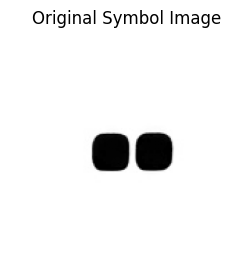

In [93]:
image_path = "Numbers/1.png" 

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found")

plt.figure(figsize=(3,3))
plt.imshow(img, cmap="gray")
plt.title("Original Symbol Image")
plt.axis("off")
plt.show()


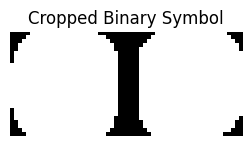

In [94]:
# Threshold to binary
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

# Crop tightly
ys, xs = np.where(binary > 127)
symbol = binary[ys.min():ys.max()+1, xs.min():xs.max()+1]


# Remove empty rows at top and bottom
rows_with_fg = np.where(np.mean(symbol > 127, axis=1) > 0.45)[0]

if len(rows_with_fg) > 0:
    symbol = symbol[rows_with_fg[0]:rows_with_fg[-1]+1, :]



plt.figure(figsize=(3,3))
plt.imshow(symbol, cmap="gray")
plt.title("Cropped Binary Symbol")
plt.axis("off")
plt.show()


2×4 Grid:
[0 1]
[0 0]
[0 0]
[0 1]


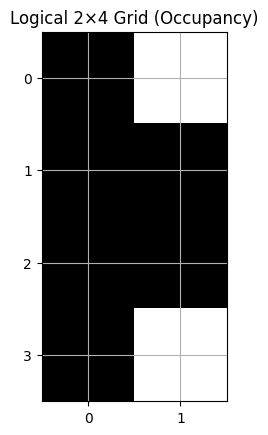

In [104]:
if np.mean(symbol) > 127:
    symbol = 255 - symbol
    
row_occ = np.mean(symbol > 127, axis=1)

# Keep only rows with strong foreground presence
rows = np.where(row_occ > 0.5)[0]

# Safety check
if len(rows) > 0:
    symbol = symbol[rows[0]:rows[-1] + 1, :]

GRID_W, GRID_H = 2, 4
h, w = symbol.shape

cell_h = h // GRID_H
cell_w = w // GRID_W

grid = np.zeros((GRID_H, GRID_W), dtype=int)

for r in range(GRID_H):
    for c in range(GRID_W):
        y0 = int(r * h / GRID_H)
        y1 = int((r + 1) * h / GRID_H)
        x0 = int(c * w / GRID_W)
        x1 = int((c + 1) * w / GRID_W)

        cell = symbol[y0:y1, x0:x1]

        # foreground = white pixels
        occupancy = np.mean(cell > 127)

        if occupancy > 0.21:
            grid[r, c] = 1

print("2×4 Grid:")
for row in grid:
    print(row)

plt.imshow(grid, cmap="gray", vmin=0, vmax=1)
plt.xticks([0,1])
plt.yticks([0,1,2,3])
plt.grid(True)
plt.title("Logical 2×4 Grid (Occupancy)")
plt.show()


In [ ]:
key = tuple(tuple(row) for row in grid)
digit = DIGIT_MAP.get(key, -1)

print("Detected number:", digit)



Detected number: -1



===== Testing 0.png =====
3×3 Grid:
[1 1 1]
[1 1 1]
[1 1 1]


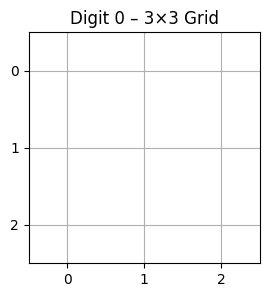

Detected number: -1
Components: 1

===== Testing 1.png =====
3×3 Grid:
[1 0 1]
[1 0 1]
[1 0 1]


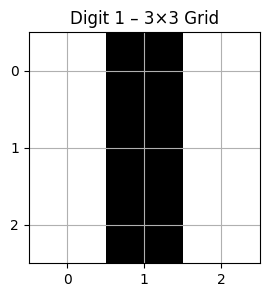

Detected number: -1
Components: 2

===== Testing 2.png =====
3×3 Grid:
[1 0 1]
[0 0 0]
[0 0 1]


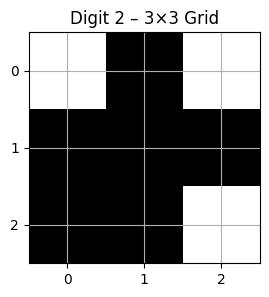

Detected number: -1
Components: 3

===== Testing 3.png =====
3×3 Grid:
[1 0 1]
[0 0 1]
[0 0 1]


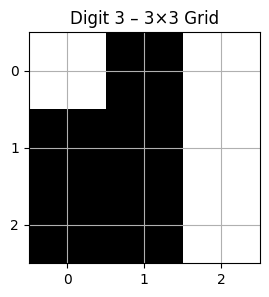

Detected number: -1
Components: 4

===== Testing 4.png =====
3×3 Grid:
[1 0 1]
[1 0 0]
[1 0 0]


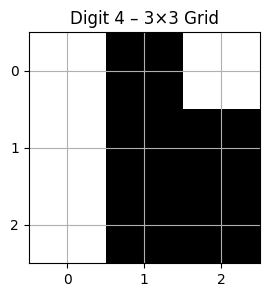

Detected number: -1
Components: 2

===== Testing 5.png =====
3×3 Grid:
[1 0 1]
[1 0 1]
[1 0 1]


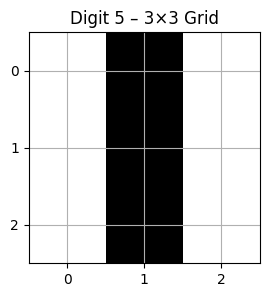

Detected number: -1
Components: 3

===== Testing 6.png =====
3×3 Grid:
[1 0 1]
[1 0 1]
[0 0 1]


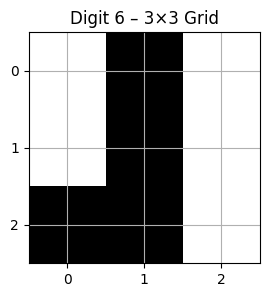

Detected number: -1
Components: 4

===== Testing 7.png =====
3×3 Grid:
[1 0 1]
[1 0 0]
[1 0 0]


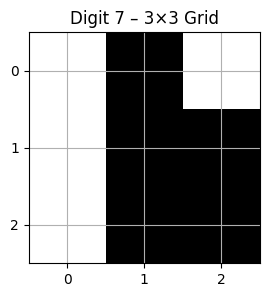

Detected number: -1
Components: 2

===== Testing 8.png =====
3×3 Grid:
[1 0 1]
[1 0 1]
[1 0 0]


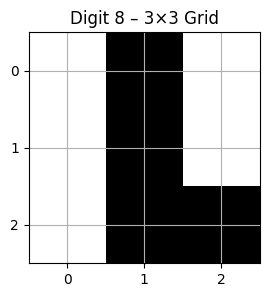

Detected number: -1
Components: 3

===== Testing 9.png =====
3×3 Grid:
[1 0 1]
[1 0 1]
[1 0 1]


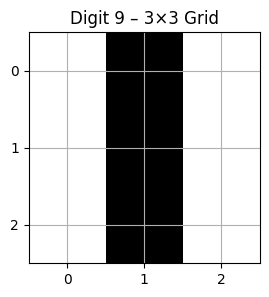

Detected number: -1
Components: 4


In [ ]:
GRID_W, GRID_H = 3, 3

for digit in range(10):
    print(f"\n===== Testing {digit}.png =====")

    img = cv2.imread(f"Numbers/{digit}.png", cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Image not found")
        continue

    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    ys, xs = np.where(binary > 127)
    if len(xs) == 0:
        print("No foreground detected")
        continue

    symbol = binary[ys.min():ys.max()+1, xs.min():xs.max()+1]

    num_labels, _ = cv2.connectedComponents((symbol > 127).astype(np.uint8))
    num_components = num_labels - 1


    h, w = symbol.shape
    grid = np.zeros((GRID_H, GRID_W), dtype=int)

    for r in range(GRID_H):
        for c in range(GRID_W):
            y0 = int(r * h / GRID_H)
            y1 = int((r + 1) * h / GRID_H)
            x0 = int(c * w / GRID_W)
            x1 = int((c + 1) * w / GRID_W)

            y1 = max(y1, y0 + 1)
            x1 = max(x1, x0 + 1)

            cell = symbol[y0:y1, x0:x1]
            occupancy = np.mean(cell > 127)

            if occupancy > 0.75:
                grid[r, c] = 1


    print("3×3 Grid:")
    for row in grid:
        print(row)

    plt.figure(figsize=(3,3))
    plt.imshow(grid, cmap="gray", vmin=0, vmax=1)
    plt.title(f"Digit {digit} – 3×3 Grid")
    plt.xticks([0,1,2])
    plt.yticks([0,1,2])
    plt.grid(True)
    plt.show()


    grid_key = tuple(tuple(row) for row in grid)
    detected_digit = DIGIT_MAP.get(grid_key, -1)

    print("Detected number:", detected_digit)
    print("Components:", num_components)



===== Testing test5.png =====


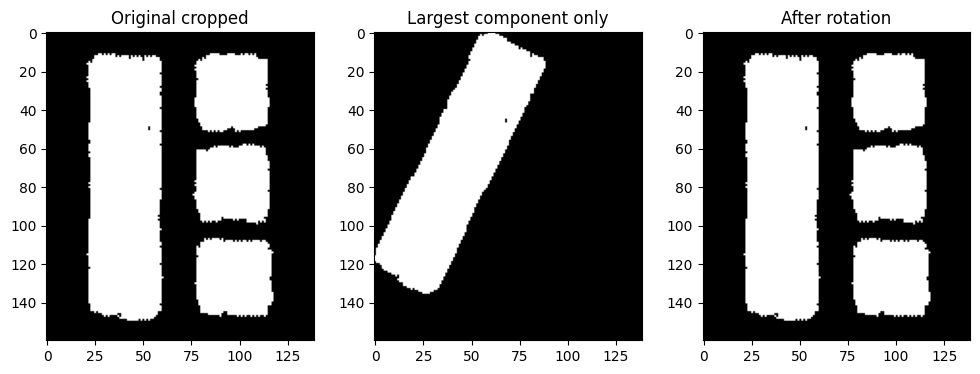

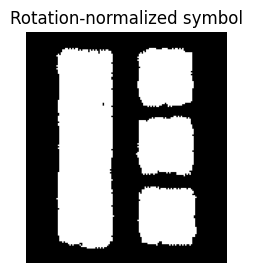

3×3 Grid:
[1 1 1]
[1 1 1]
[1 1 1]
Components: 4
Detected number: 9


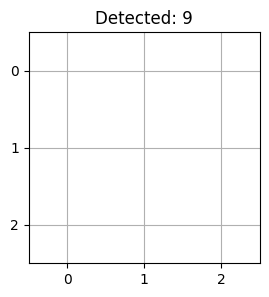

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

GRID_W, GRID_H = 3, 3

print("\n===== Testing test5.png =====")

img = cv2.imread("Numbers/rot9.png", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found")

_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

ys, xs = np.where(binary > 127)
if len(xs) == 0:
    raise ValueError("No foreground detected")

symbol = binary[ys.min():ys.max()+1, xs.min():xs.max()+1]


num_labels, labels = cv2.connectedComponents((symbol > 127).astype(np.uint8))
num_components = num_labels - 1



largest_label = 1
max_area = 0

for label in range(1, num_labels):
    area = np.sum(labels == label)
    if area > max_area:
        max_area = area
        largest_label = label

main_component = (labels == largest_label).astype(np.uint8) * 255


coords = np.column_stack(np.where(main_component > 0)[::-1])

rect = cv2.minAreaRect(coords)
angle = rect[-1]

if angle < -45:
    angle += 90


# Rotate to upright
(h, w) = symbol.shape
center = (w // 2, h // 2)

M = cv2.getRotationMatrix2D(center, angle, 1.0)
symbol = cv2.warpAffine(
    symbol,
    M,
    (w, h),
    flags=cv2.INTER_NEAREST,
    borderValue=0
)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(symbol, cmap="gray")
plt.title("Original cropped")

plt.subplot(1,3,2)
plt.imshow(main_component, cmap="gray")
plt.title("Largest component only")

plt.subplot(1,3,3)
plt.imshow(symbol, cmap="gray")
plt.title("After rotation")

plt.show()


plt.figure(figsize=(3,3))
plt.imshow(symbol, cmap="gray")
plt.title("Rotation-normalized symbol")
plt.axis("off")
plt.show()



h, w = symbol.shape
grid = np.zeros((GRID_H, GRID_W), dtype=int)

for r in range(GRID_H):
    for c in range(GRID_W):
        y0 = int(r * h / GRID_H)
        y1 = int((r + 1) * h / GRID_H)
        x0 = int(c * w / GRID_W)
        x1 = int((c + 1) * w / GRID_W)

        y1 = max(y1, y0 + 1)
        x1 = max(x1, x0 + 1)

        cell = symbol[y0:y1, x0:x1]
        occupancy = np.mean(cell > 127)

        if occupancy > 0.3:
            grid[r, c] = 1


grid_key = tuple(tuple(row) for row in grid)
key = (grid_key, num_components)
detected_digit = DIGIT_MAP.get(key, -1)


print("3×3 Grid:")
for row in grid:
    print(row)

print("Components:", num_components)
print("Detected number:", detected_digit)

plt.figure(figsize=(3,3))
plt.imshow(grid, cmap="gray", vmin=0, vmax=1)
plt.title(f"Detected: {detected_digit}")
plt.xticks([0,1,2])
plt.yticks([0,1,2])
plt.grid(True)
plt.show()
